# HiddenLayer Training Demo - PyTorch

In [1]:
import os
import time
import random
import numpy as np
import torch
import torchvision.models
import torch.nn as nn
from torchvision import datasets, transforms
import hiddenlayer as hl

## Basic Use Case

To track your training, you need to use two Classes: History to store the metrics, and Canvas to draw them.
This example simulates a training loop.

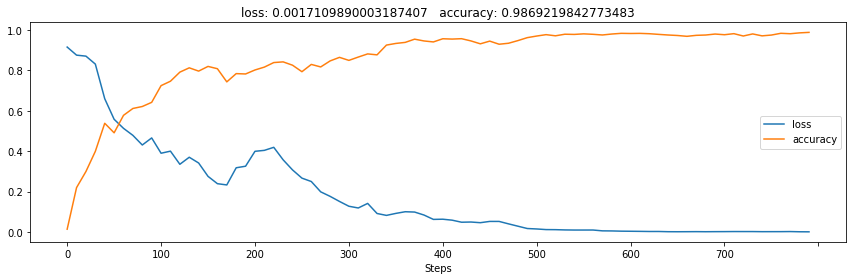

In [2]:
# A History object to store metrics
history1 = hl.History()

# A Canvas object to draw the metrics
canvas1 = hl.Canvas()

# Simulate a training loop with two metrics: loss and accuracy
loss = 1
accuracy = 0
for step in range(800):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))

    # Log metrics and display them at certain intervals
    if step % 10 == 0:
        # Store metrics in the history object
        history1.log(step, loss=loss, accuracy=accuracy)

        # Plot the two metrics in one graph
        canvas1.draw_plot([history1["loss"], history1["accuracy"]])

        time.sleep(0.1)

## Comparing Experiments

Often you'd want to compare how experiments compare to each other. 

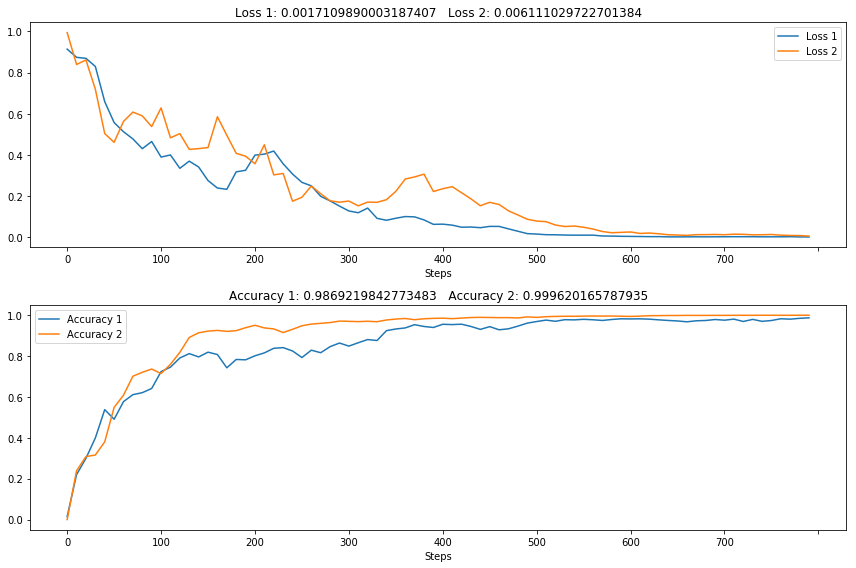

In [3]:
# New history and canvas objects
history2 = hl.History()
canvas2 = hl.Canvas()

# Simulate a training loop with two metrics: loss and accuracy
loss = 1
accuracy = 0
for step in range(800):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))

    # Log metrics and display them at certain intervals
    if step % 10 == 0:
        history2.log(step, loss=loss, accuracy=accuracy)

        # Draw two plots
        # Encluse them in a "with" context to ensure they render together
        with canvas2:
            canvas2.draw_plot([history1["loss"], history2["loss"]],
                              labels=["Loss 1", "Loss 2"])
            canvas2.draw_plot([history1["accuracy"], history2["accuracy"]],
                              labels=["Accuracy 1", "Accuracy 2"])
        time.sleep(0.1)

## Saving and Loading Histories

The History object store the metrics in RAM, which is often good enough for simple 
expriments. To keep the history, you can save/load them with.

In [4]:
# Save experiments 1 and 2
history1.save("experiment1.pkl")
history2.save("experiment2.pkl")

In [5]:
# Load them again. To verify it's working, load them into new objects.
h1 = hl.History()
h2 = hl.History()
h1.load("experiment1.pkl")
h2.load("experiment2.pkl")

Verify the data is loaded

In [6]:
# Show a summary of the experiment
h1.summary()

Last Step: 790
Training Time: 0:00:29.312315


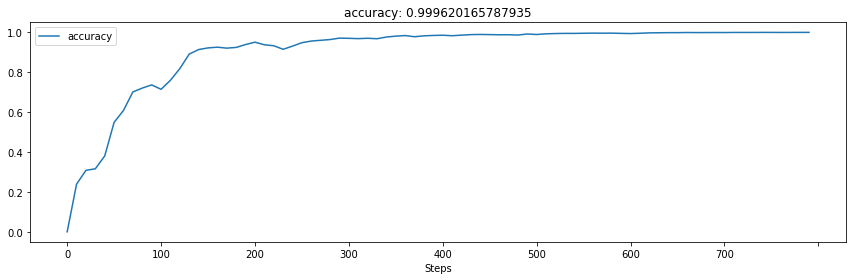

In [7]:
# Draw a plot of experiment 2
hl.Canvas().draw_plot(h2["accuracy"])

## Custom Visualizations

Adding new custom visualizations is pretty easy. Derive a new class from `Canvas` and add your new method to it. You can use any of the drawing functions provided by `matplotlib`.

Here is an example to display the accuracy metric as a pie chart.

In [8]:
class MyCanvas(hl.Canvas):
    """Extending Canvas to add a pie chart method."""
    
    def draw_pie(self, metric):
        # Method name must start with 'draw_' for the Canvas to automatically manage it
        
        # Use the provided matplotlib Axes in self.ax
        self.ax.axis('equal')  # set square aspect ratio

        # Get latest value of the metric
        value = np.clip(metric.data[-1], 0, 1)
        
        # Draw pie chart
        self.ax.pie([value, 1-value], labels=["Accuracy", ""])

In addition to the pie chart, let's use image visualizations (which is built-in).

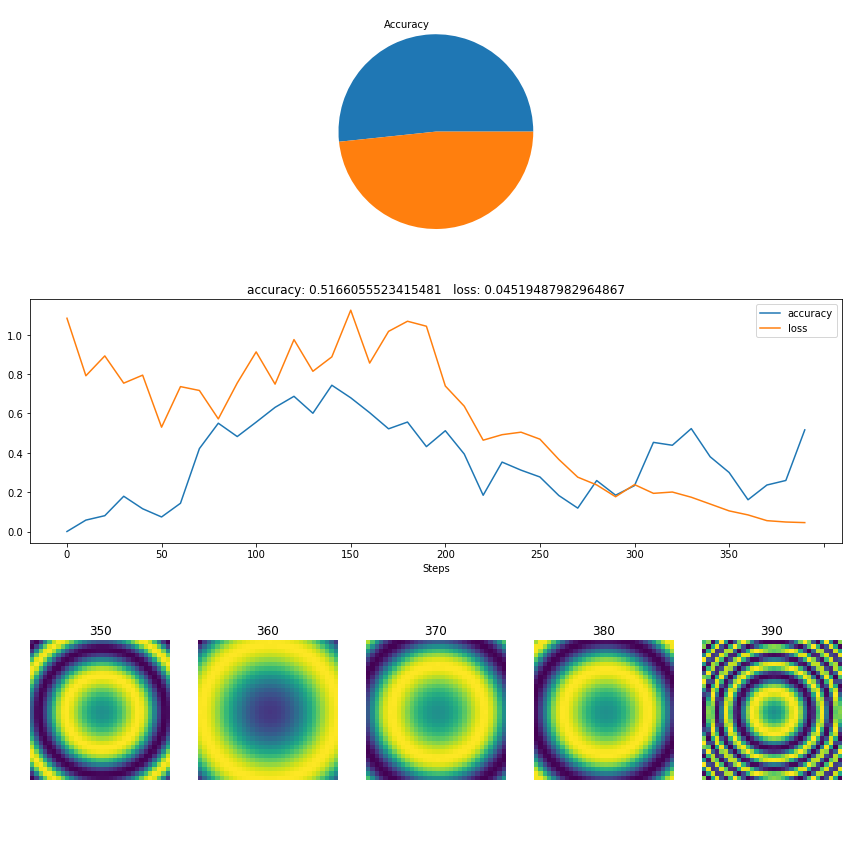

In [9]:
history3 = hl.History()
canvas3 = MyCanvas()  # My custom Canvas

# Simulate a training loop
loss = 1
accuracy = 0
for step in range(400):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))

    if step % 10 == 0:
        # Log loss and accuracy
        history3.log(step, loss=loss, accuracy=accuracy)

        # Log a fake image metric (e.g. image generated by a GAN)
        image = np.sin(np.sum(((np.indices([32, 32]) - 16) * 0.5 * accuracy) ** 2, 0))
        history3.log(step, image=image)
        
        # Display
        with canvas3:
            canvas3.draw_pie(history3["accuracy"])
            canvas3.draw_plot([history3["accuracy"], history3["loss"]])
            canvas3.draw_image(history3["image"])

        time.sleep(0.1)

## Running without a GUI

If the training loop is running on a server without a GUI, then use the `History` `progress()` method to print a text status.

In [10]:
# Print the metrics of the last step.
history1.progress()

Step 790: loss: 0.0017109890003187407  accuracy: 0.9869219842773483  


You can also periodically saving a snapshot of the graphs to disk to view later. See `demos/history_demo.py` for an example.

First, set matplotlib backend to Agg.
```Python
# Set matplotlib backend to Agg. MUST be done BEFORE importing hiddenlayer
import matplotlib
matplotlib.use("Agg")
```

Then, in the training loop:
```
    # Print a text progress status in the loop
    history.progress()

    # Occasionally, save a snapshot of the graphs.
    canvas.draw_plot([h["loss"], h["accuracy"]])
    canvas.save("training_graph.png")
```

## Real Training Example

In [11]:
# Create data directory in project root (to download dataset to)
ROOT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
DATA_DIR = os.path.join(ROOT_DIR, "test_data")

In [12]:
# CIFAR10 Dataset
t = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(DATA_DIR, train=True, download=True, transform=t)
test_dataset = datasets.CIFAR10(DATA_DIR, train=False, download=True, transform=t)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# Print dataset stats
hl.write("train_dataset.data", train_dataset.train_data)
hl.write("train_dataset.labels", train_dataset.train_labels)
hl.write("test_dataset.data", test_dataset.test_data)
hl.write("test_dataset.labels", test_dataset.test_labels)

train_dataset.data	Tensor  uint8 (50000, 32, 32, 3)  min: 0.000  max: 255.000
train_dataset.labels	list    len: 50000  [6, 9, 9, 4, 1, 1, 2, 7, 8, 3]
test_dataset.data	Tensor  uint8 (10000, 32, 32, 3)  min: 0.000  max: 255.000
test_dataset.labels	list    len: 10000  [3, 8, 8, 0, 6, 6, 1, 6, 3, 1]


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device = ", device)

device =  cuda:0


In [15]:
# Simple Convolutional Network
class CifarModel(nn.Module):
    def __init__(self):
        super(CifarModel, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.AdaptiveMaxPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32, 32),
#             TODO: nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Linear(32, 10))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CifarModel().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

/home/waleed/miniconda3/envs/dl/lib/python3.6/site-packages/torch/onnx/utils.py:446: UserWarning: ONNX export failed on ATen operator adaptive_max_pool2d because torch.onnx.symbolic.adaptive_max_pool2d does not exist
  .format(op_name, op_name))


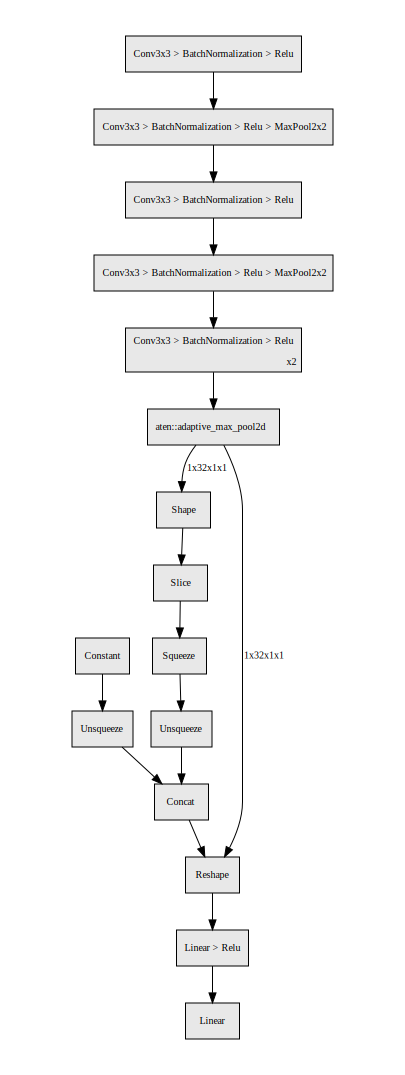

In [16]:
hl.build_graph(model, torch.zeros([1, 3, 32, 32]).to(device))

In [17]:
def activations_hook(self, inputs, output):
    """Intercepts the forward pass and logs activations.
    """
    batch_ix = step[1]
    if batch_ix and batch_ix % 100 == 0:
        # The output of this layer is of shape [batch_size, 16, 32, 32]
        # Take a slice that represents one feature map
        cifar_history.log(step, conv1_output=output.data[0, 0])
    
# A hook to extract the activations of intermediate layers
model.features[0].register_forward_hook(activations_hook);

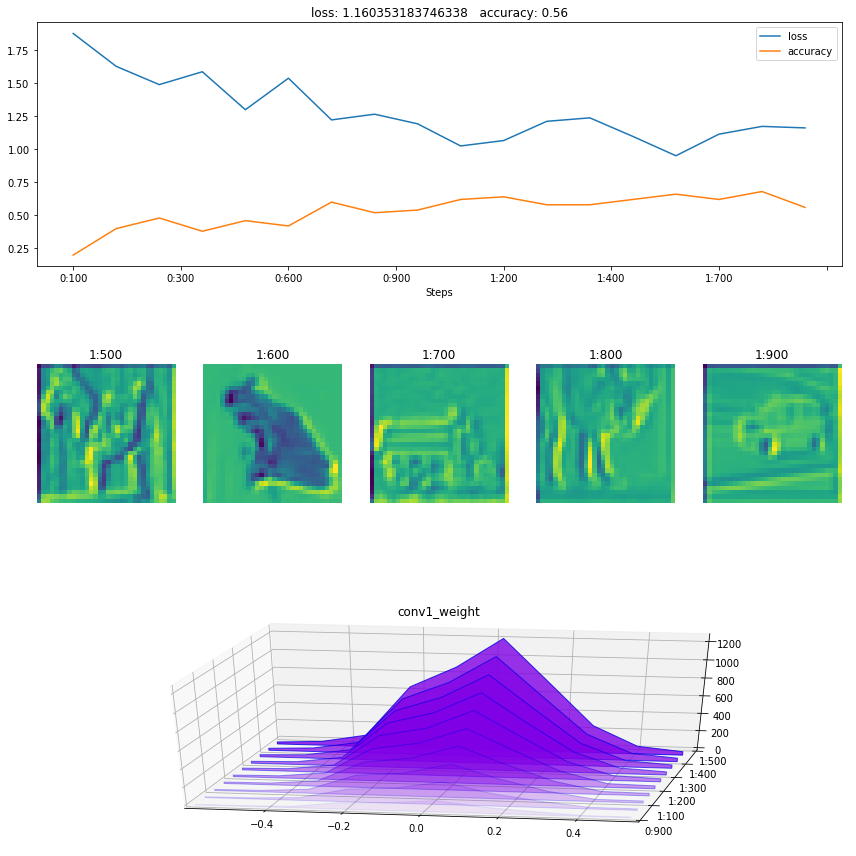

In [18]:
step = (0, 0)  # tuple of (epoch, batch_ix)
cifar_history = hl.History()
cifar_canvas = hl.Canvas()

# Training loop
for epoch in range(2):
    train_iter = iter(train_loader)
    for batch_ix, (inputs, labels) in enumerate(train_iter):
        # Update global step counter
        step = (epoch, batch_ix)

        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        if batch_ix and batch_ix % 100 == 0:
            # Compute accuracy
            pred_labels = np.argmax(outputs.detach().cpu().numpy(), 1)
            accuracy = np.mean(pred_labels == labels.detach().cpu().numpy())
            # Log metrics to history
            cifar_history.log((epoch, batch_ix),
                              loss=loss, accuracy=accuracy,
                              conv1_weight=model.features[0].weight)
            # Visualize metrics
            with cifar_canvas:
                cifar_canvas.draw_plot([cifar_history["loss"], cifar_history["accuracy"]])
                cifar_canvas.draw_image(cifar_history["conv1_output"])
                cifar_canvas.draw_hist(cifar_history["conv1_weight"])
